# Deep Learning: Endoscopy segmentation.
[Dataset](https://www.kaggle.com/datasets/newslab/cholecseg8k?resource=download)

In [1]:
import os

os.environ["CUBLAS_WORKSPACE_CONFIG"]=":4096:8"

In [2]:
import torch
from glob import glob
import numpy as np
import time
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import cv2
import random
from pytorch_Uformer import model
from pytorch_Uformer import losses
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [3]:
torch.cuda.is_available(), torch.cuda.get_device_name(0)

(True, 'NVIDIA GeForce RTX 2060 SUPER')

In [4]:
SEED = 33
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.use_deterministic_algorithms(True)

In [5]:
CLASS_WEIGHTS = np.array([2.45780159e-01, 2.24610010e-01, 2.24005501e-01, 1.87119512e-02,
 1.46965911e-01, 2.54698498e-02, 2.35562466e-02, 4.28713053e-03,
 3.93593665e-04, 1.38500705e-02, 6.78984614e-02, 1.01436955e-04,
 4.36967906e-03])

In [6]:
# determine the device to be used for training and evaluation
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# determine if we will be pinning memory during data loading
PIN_MEMORY = True if DEVICE == "cuda" else False

NUM_CLASSES = 13
# initialize learning rate, number of epochs to train for, and the
# batch size
INIT_LR = 0.0012
NUM_EPOCHS = 100
BATCH_SIZE = 45
# define the input image dimensions
INPUT_IMAGE_WIDTH = 64
INPUT_IMAGE_HEIGHT = 64

## Data preparation.

In [7]:
IMAGE_DATASET_PATH = glob(f'../*/*/*/frame_*_endo.png')
MASK_DATASET_PATH  = glob(f'../*/*/*/frame_*_endo_watershed_mask.png')
N = len(IMAGE_DATASET_PATH)
assert len(IMAGE_DATASET_PATH) == len(MASK_DATASET_PATH)

print(f'Number of samples: {str(len(MASK_DATASET_PATH))}')

Number of samples: 8080


In [8]:
def to_categorical(y, num_classes=None, dtype="float32"):
	y = np.array(y, dtype="int")
	input_shape = y.shape

	# Shrink the last dimension if the shape is (..., 1).
	if input_shape and input_shape[-1] == 1 and len(input_shape) > 1:
		input_shape = tuple(input_shape[:-1])

	y = y.reshape(-1)
	if not num_classes:
		num_classes = np.max(y) + 1
	n = y.shape[0]
	categorical = np.zeros((n, num_classes), dtype=dtype)
	categorical[np.arange(n), y] = 1
	output_shape = input_shape + (num_classes,)
	categorical = np.reshape(categorical, output_shape)
	return categorical

labels = [[11],[21],[13],[12],[31],[23],[24],[25],[32],[22],[33],[5]]
def encode_mask(masks_arr, n_classes=NUM_CLASSES, H=INPUT_IMAGE_HEIGHT, W=INPUT_IMAGE_WIDTH, labels_arr=labels):
    y_encoded = np.zeros((H, W, 1), dtype=np.uint8)

    for i, label in enumerate(labels_arr):
        y_encoded[np.all(label == masks_arr, axis=-1)] = i + 1
    
    return to_categorical(y_encoded, num_classes=n_classes)

class SegmentationDataset(Dataset):
	def __init__(self, imagePaths, maskPaths):
		# store the image and mask filepaths, and augmentation
		# transforms
		self.imagePaths = imagePaths
		self.maskPaths = maskPaths

	def __len__(self):
		# return the number of total samples contained in the dataset
		return len(self.imagePaths)
	
	def __getitem__(self, idx):
		# grab the image path from the current index
		imagePath = self.imagePaths[idx]
		# load the image from disk, swap its channels from BGR to RGB,
		# and read the associated mask from disk in grayscale mode
		image = cv2.imread(imagePath)
		image = image[10:-10, 10:-10,:]
		image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
		image = cv2.resize(image, (INPUT_IMAGE_WIDTH, INPUT_IMAGE_HEIGHT))
		image = image / 255
		image = torch.from_numpy(np.float32(image))
		image = image.permute(2,0,1)

		mask = cv2.imread(self.maskPaths[idx])
		mask = mask[10:-10, 10:-10,:]
		mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
		mask = cv2.resize(mask, (INPUT_IMAGE_WIDTH, INPUT_IMAGE_HEIGHT), interpolation=cv2.INTER_NEAREST)
		mask = np.expand_dims(mask, axis=-1)
		mask = encode_mask(mask)
		mask = torch.from_numpy(np.float32(mask))
		mask = mask.permute(2,0,1)

		assert image.shape == (3, INPUT_IMAGE_HEIGHT, INPUT_IMAGE_WIDTH), f"Bad image shape {image.shape}"
		assert mask.shape == (13, INPUT_IMAGE_HEIGHT, INPUT_IMAGE_WIDTH), f"Bad mask shape {mask.shape}"

		# return a tuple of the image and its mask
		return image, mask

In [9]:
uformer = model.Uformer(img_size=INPUT_IMAGE_HEIGHT,in_chans=13, embed_dim=16, win_size=8, token_projection='linear', token_mlp='leff',modulator=True)
trainImages, testImages, trainMasks, testMasks = train_test_split(IMAGE_DATASET_PATH, MASK_DATASET_PATH, test_size=0.2, random_state=43)

c:\Users\alexg\miniconda3\envs\pytorch-gpu\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [10]:
# define transformations
from torch.utils.data import DataLoader

# create the train and test datasets
trainDS = SegmentationDataset(imagePaths=trainImages, maskPaths=trainMasks)
testDS = SegmentationDataset(imagePaths=testImages, maskPaths=testMasks)
print(f"[INFO] found {len(trainDS)} examples in the training set...")
print(f"[INFO] found {len(testDS)} examples in the test set...")
# create the training and test data loaders
num_workers = 4
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(0)

trainLoader = DataLoader(
	trainDS, 
	shuffle=True,
	batch_size=BATCH_SIZE, 
	pin_memory=PIN_MEMORY,
    worker_init_fn=seed_worker,
    generator=g
)
testLoader = DataLoader(
	testDS, shuffle=False,
	batch_size=BATCH_SIZE, 
	pin_memory=PIN_MEMORY,
    worker_init_fn=seed_worker,
    generator=g
)

[INFO] found 6464 examples in the training set...
[INFO] found 1616 examples in the test set...


In [11]:
uformer = uformer.to(DEVICE)
softmax = torch.nn.Softmax(1)
# initialize loss function and optimizer
lossFunc = losses.DiceLoss(class_weights=CLASS_WEIGHTS).cuda()
opt = torch.optim.Adam(uformer.parameters(), lr=INIT_LR, betas=(0.9, 0.999),eps=1e-8, weight_decay=1e-5)
iouMetric = losses.MeanIoU().cuda()
gdlMetric = losses.DiceCoeficient().cuda()
# calculate steps per epoch for training and test set
trainSteps = len(trainDS) // BATCH_SIZE
testSteps = len(testDS) // BATCH_SIZE
# initialize a dictionary to store training history
H = {"train_loss": [], "test_loss": [], "train_IoU": [], "test_IoU": [],"train_DC": [], "test_DC": []}

In [12]:
# loop over epochs
print("[INFO] training the network...")
startTime = time.time()
for e in range(NUM_EPOCHS):
	# set the model in training mode
	uformer.train()
	# initialize the total training and validation loss
	totalTrainLoss = 0
	totalTestLoss = 0

	totalTrainIoU = 0
	totalTestIoU = 0
	totalTrainDC = 0
	totalTestDC = 0
	# loop over the training set
	for i, (x, y) in enumerate(tqdm(trainLoader)):
		# send the input to the device
		x, y = x.to(DEVICE), y.to(DEVICE)
		# perform a forward pass and calculate the training loss
		pred = uformer(x)
		assert pred.shape == y.shape, f"{pred.shape} != {y.shape}" # B, C, H, W
		pred = softmax(pred)
		loss = lossFunc(pred, y)
		# first, zero out any previously accumulated gradients, then
		# perform backpropagation, and then update model parameters
		opt.zero_grad()
		loss.backward()
		opt.step()
		# add the loss to the total training loss so far
		totalTrainLoss += loss
		totalTrainIoU += iouMetric(pred, y)
		totalTrainDC += gdlMetric(pred, y)
	# switch off autograd
	with torch.no_grad():
		# set the model in evaluation mode
		uformer.eval()
		# loop over the validation set
		for (x, y) in testLoader:
			# send the input to the device
			(x, y) = (x.to(DEVICE), y.to(DEVICE))
			# make the predictions and calculate the validation loss
			pred = uformer(x)
			assert pred.shape == y.shape, f"{pred.shape} != {y.shape}" # B, C, H, W
			pred = softmax(pred)
			totalTestLoss += lossFunc(pred, y)
			totalTestIoU += iouMetric(pred, y)
			totalTestDC += gdlMetric(pred, y)
			
	# calculate the average training and validation loss
	avgTrainLoss = totalTrainLoss / trainSteps
	avgTestLoss = totalTestLoss / testSteps

	avgTrainIoU = totalTrainIoU / trainSteps
	avgTestIoU = totalTestIoU / testSteps
	avgTrainDC = totalTrainDC / trainSteps
	avgTestDC = totalTestDC / testSteps
	# update our training history
	H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
	H["test_loss"].append(avgTestLoss.cpu().detach().numpy())

	H["train_IoU"].append(avgTrainIoU.cpu().detach().numpy())
	H["test_IoU"].append(avgTestIoU.cpu().detach().numpy())
	H["train_DC"].append(avgTrainDC.cpu().detach().numpy())
	H["test_DC"].append(avgTestDC.cpu().detach().numpy())

	# print the model training and validation information
	print("[INFO] EPOCH: {}/{}".format(e + 1, NUM_EPOCHS))
	print(f"Train loss: {avgTrainLoss:.6f}, Test loss: {avgTestLoss:.4f}, " + 
       f"Train IoU: {avgTrainIoU:.4f}, Test IoU: {avgTestIoU:.4f}, Train Dice: {avgTrainDC:.4f}, Test Dice: {avgTestDC:.4f}")

# display the total time needed to perform the training
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(endTime - startTime))

[INFO] training the network...


100%|██████████| 144/144 [01:51<00:00,  1.29it/s]


[INFO] EPOCH: 1/100
Train loss: 0.967522, Test loss: 0.9757, Train IoU: 0.3793, Test IoU: 0.5531, Train Dice: 0.5376, Test Dice: 0.7169


100%|██████████| 144/144 [01:54<00:00,  1.26it/s]


[INFO] EPOCH: 2/100
Train loss: 0.949337, Test loss: 0.9658, Train IoU: 0.6446, Test IoU: 0.7241, Train Dice: 0.7811, Test Dice: 0.8462


100%|██████████| 144/144 [01:58<00:00,  1.21it/s]


[INFO] EPOCH: 3/100
Train loss: 0.944470, Test loss: 0.9635, Train IoU: 0.7298, Test IoU: 0.7679, Train Dice: 0.8429, Test Dice: 0.8763


100%|██████████| 144/144 [01:59<00:00,  1.21it/s]


[INFO] EPOCH: 4/100
Train loss: 0.942836, Test loss: 0.9623, Train IoU: 0.7617, Test IoU: 0.7927, Train Dice: 0.8644, Test Dice: 0.8926


100%|██████████| 144/144 [01:59<00:00,  1.20it/s]


[INFO] EPOCH: 5/100
Train loss: 0.942072, Test loss: 0.9622, Train IoU: 0.7771, Test IoU: 0.7960, Train Dice: 0.8744, Test Dice: 0.8948


100%|██████████| 144/144 [01:59<00:00,  1.21it/s]


[INFO] EPOCH: 6/100
Train loss: 0.941669, Test loss: 0.9615, Train IoU: 0.7841, Test IoU: 0.8062, Train Dice: 0.8788, Test Dice: 0.9011


100%|██████████| 144/144 [01:59<00:00,  1.21it/s]


[INFO] EPOCH: 7/100
Train loss: 0.941214, Test loss: 0.9613, Train IoU: 0.7912, Test IoU: 0.7946, Train Dice: 0.8831, Test Dice: 0.8925


100%|██████████| 144/144 [01:59<00:00,  1.21it/s]


[INFO] EPOCH: 8/100
Train loss: 0.939842, Test loss: 0.9591, Train IoU: 0.7996, Test IoU: 0.8302, Train Dice: 0.8882, Test Dice: 0.9162


100%|██████████| 144/144 [01:59<00:00,  1.20it/s]


[INFO] EPOCH: 9/100
Train loss: 0.939196, Test loss: 0.9592, Train IoU: 0.8098, Test IoU: 0.8265, Train Dice: 0.8952, Test Dice: 0.9143


100%|██████████| 144/144 [01:59<00:00,  1.20it/s]


[INFO] EPOCH: 10/100
Train loss: 0.938652, Test loss: 0.9583, Train IoU: 0.8198, Test IoU: 0.8455, Train Dice: 0.9015, Test Dice: 0.9256


100%|██████████| 144/144 [01:59<00:00,  1.21it/s]


[INFO] EPOCH: 11/100
Train loss: 0.938377, Test loss: 0.9581, Train IoU: 0.8247, Test IoU: 0.8478, Train Dice: 0.9045, Test Dice: 0.9275


100%|██████████| 144/144 [01:59<00:00,  1.20it/s]


[INFO] EPOCH: 12/100
Train loss: 0.938083, Test loss: 0.9579, Train IoU: 0.8299, Test IoU: 0.8521, Train Dice: 0.9079, Test Dice: 0.9301


100%|██████████| 144/144 [01:59<00:00,  1.20it/s]


[INFO] EPOCH: 13/100
Train loss: 0.937873, Test loss: 0.9576, Train IoU: 0.8340, Test IoU: 0.8576, Train Dice: 0.9105, Test Dice: 0.9337


100%|██████████| 144/144 [01:58<00:00,  1.22it/s]


[INFO] EPOCH: 14/100
Train loss: 0.937666, Test loss: 0.9575, Train IoU: 0.8380, Test IoU: 0.8602, Train Dice: 0.9130, Test Dice: 0.9352


100%|██████████| 144/144 [01:54<00:00,  1.26it/s]


[INFO] EPOCH: 15/100
Train loss: 0.937329, Test loss: 0.9571, Train IoU: 0.8425, Test IoU: 0.8621, Train Dice: 0.9156, Test Dice: 0.9362


100%|██████████| 144/144 [01:56<00:00,  1.23it/s]


[INFO] EPOCH: 16/100
Train loss: 0.936541, Test loss: 0.9563, Train IoU: 0.8568, Test IoU: 0.8787, Train Dice: 0.9242, Test Dice: 0.9463


100%|██████████| 144/144 [01:56<00:00,  1.24it/s]


[INFO] EPOCH: 17/100
Train loss: 0.936191, Test loss: 0.9562, Train IoU: 0.8651, Test IoU: 0.8831, Train Dice: 0.9292, Test Dice: 0.9488


100%|██████████| 144/144 [01:54<00:00,  1.26it/s]


[INFO] EPOCH: 18/100
Train loss: 0.936121, Test loss: 0.9563, Train IoU: 0.8662, Test IoU: 0.8839, Train Dice: 0.9299, Test Dice: 0.9496


100%|██████████| 144/144 [01:54<00:00,  1.26it/s]


[INFO] EPOCH: 19/100
Train loss: 0.936072, Test loss: 0.9559, Train IoU: 0.8679, Test IoU: 0.8890, Train Dice: 0.9309, Test Dice: 0.9525


100%|██████████| 144/144 [01:54<00:00,  1.26it/s]


[INFO] EPOCH: 20/100
Train loss: 0.935711, Test loss: 0.9555, Train IoU: 0.8711, Test IoU: 0.8802, Train Dice: 0.9328, Test Dice: 0.9472


100%|██████████| 144/144 [01:55<00:00,  1.25it/s]


[INFO] EPOCH: 21/100
Train loss: 0.935310, Test loss: 0.9552, Train IoU: 0.8712, Test IoU: 0.8890, Train Dice: 0.9329, Test Dice: 0.9524


100%|██████████| 144/144 [01:54<00:00,  1.26it/s]


[INFO] EPOCH: 22/100
Train loss: 0.934423, Test loss: 0.9537, Train IoU: 0.8944, Test IoU: 0.9314, Train Dice: 0.9461, Test Dice: 0.9766


100%|██████████| 144/144 [01:54<00:00,  1.26it/s]


[INFO] EPOCH: 23/100
Train loss: 0.933707, Test loss: 0.9535, Train IoU: 0.9125, Test IoU: 0.9371, Train Dice: 0.9564, Test Dice: 0.9796


100%|██████████| 144/144 [01:54<00:00,  1.26it/s]


[INFO] EPOCH: 24/100
Train loss: 0.933527, Test loss: 0.9533, Train IoU: 0.9165, Test IoU: 0.9399, Train Dice: 0.9586, Test Dice: 0.9812


100%|██████████| 144/144 [01:58<00:00,  1.22it/s]


[INFO] EPOCH: 25/100
Train loss: 0.933488, Test loss: 0.9534, Train IoU: 0.9173, Test IoU: 0.9375, Train Dice: 0.9590, Test Dice: 0.9800


100%|██████████| 144/144 [01:58<00:00,  1.22it/s]


[INFO] EPOCH: 26/100
Train loss: 0.933383, Test loss: 0.9533, Train IoU: 0.9200, Test IoU: 0.9417, Train Dice: 0.9605, Test Dice: 0.9823


100%|██████████| 144/144 [01:58<00:00,  1.22it/s]


[INFO] EPOCH: 27/100
Train loss: 0.933300, Test loss: 0.9532, Train IoU: 0.9217, Test IoU: 0.9425, Train Dice: 0.9615, Test Dice: 0.9827


100%|██████████| 144/144 [01:55<00:00,  1.25it/s]


[INFO] EPOCH: 28/100
Train loss: 0.933261, Test loss: 0.9533, Train IoU: 0.9231, Test IoU: 0.9416, Train Dice: 0.9622, Test Dice: 0.9822


100%|██████████| 144/144 [01:55<00:00,  1.25it/s]


[INFO] EPOCH: 29/100
Train loss: 0.933273, Test loss: 0.9534, Train IoU: 0.9222, Test IoU: 0.9374, Train Dice: 0.9618, Test Dice: 0.9799


100%|██████████| 144/144 [01:56<00:00,  1.24it/s]


[INFO] EPOCH: 30/100
Train loss: 0.933247, Test loss: 0.9531, Train IoU: 0.9236, Test IoU: 0.9453, Train Dice: 0.9626, Test Dice: 0.9843


100%|██████████| 144/144 [01:56<00:00,  1.24it/s]


[INFO] EPOCH: 31/100
Train loss: 0.933172, Test loss: 0.9532, Train IoU: 0.9248, Test IoU: 0.9430, Train Dice: 0.9632, Test Dice: 0.9830


100%|██████████| 144/144 [01:55<00:00,  1.25it/s]


[INFO] EPOCH: 32/100
Train loss: 0.933104, Test loss: 0.9530, Train IoU: 0.9263, Test IoU: 0.9478, Train Dice: 0.9640, Test Dice: 0.9857


100%|██████████| 144/144 [01:55<00:00,  1.25it/s]


[INFO] EPOCH: 33/100
Train loss: 0.933060, Test loss: 0.9531, Train IoU: 0.9279, Test IoU: 0.9464, Train Dice: 0.9649, Test Dice: 0.9848


100%|██████████| 144/144 [01:55<00:00,  1.25it/s]


[INFO] EPOCH: 34/100
Train loss: 0.933098, Test loss: 0.9530, Train IoU: 0.9266, Test IoU: 0.9472, Train Dice: 0.9642, Test Dice: 0.9853


100%|██████████| 144/144 [01:55<00:00,  1.25it/s]


[INFO] EPOCH: 35/100
Train loss: 0.933051, Test loss: 0.9531, Train IoU: 0.9274, Test IoU: 0.9449, Train Dice: 0.9646, Test Dice: 0.9841


100%|██████████| 144/144 [01:55<00:00,  1.25it/s]


[INFO] EPOCH: 36/100
Train loss: 0.933025, Test loss: 0.9531, Train IoU: 0.9285, Test IoU: 0.9467, Train Dice: 0.9652, Test Dice: 0.9851


100%|██████████| 144/144 [01:55<00:00,  1.25it/s]


[INFO] EPOCH: 37/100
Train loss: 0.932979, Test loss: 0.9530, Train IoU: 0.9294, Test IoU: 0.9483, Train Dice: 0.9657, Test Dice: 0.9859


100%|██████████| 144/144 [01:55<00:00,  1.25it/s]


[INFO] EPOCH: 38/100
Train loss: 0.932947, Test loss: 0.9531, Train IoU: 0.9302, Test IoU: 0.9437, Train Dice: 0.9661, Test Dice: 0.9833


100%|██████████| 144/144 [01:56<00:00,  1.23it/s]


[INFO] EPOCH: 39/100
Train loss: 0.932942, Test loss: 0.9528, Train IoU: 0.9306, Test IoU: 0.9516, Train Dice: 0.9664, Test Dice: 0.9877


100%|██████████| 144/144 [01:58<00:00,  1.22it/s]


[INFO] EPOCH: 40/100
Train loss: 0.932847, Test loss: 0.9528, Train IoU: 0.9323, Test IoU: 0.9520, Train Dice: 0.9673, Test Dice: 0.9880


100%|██████████| 144/144 [01:56<00:00,  1.23it/s]


[INFO] EPOCH: 41/100
Train loss: 0.932945, Test loss: 0.9529, Train IoU: 0.9303, Test IoU: 0.9497, Train Dice: 0.9662, Test Dice: 0.9867


100%|██████████| 144/144 [01:55<00:00,  1.25it/s]


[INFO] EPOCH: 42/100
Train loss: 0.932884, Test loss: 0.9528, Train IoU: 0.9316, Test IoU: 0.9528, Train Dice: 0.9669, Test Dice: 0.9884


100%|██████████| 144/144 [01:55<00:00,  1.25it/s]


[INFO] EPOCH: 43/100
Train loss: 0.932851, Test loss: 0.9529, Train IoU: 0.9325, Test IoU: 0.9493, Train Dice: 0.9674, Test Dice: 0.9865


100%|██████████| 144/144 [01:55<00:00,  1.25it/s]


[INFO] EPOCH: 44/100
Train loss: 0.932833, Test loss: 0.9529, Train IoU: 0.9326, Test IoU: 0.9505, Train Dice: 0.9675, Test Dice: 0.9871


100%|██████████| 144/144 [01:55<00:00,  1.25it/s]


[INFO] EPOCH: 45/100
Train loss: 0.932823, Test loss: 0.9528, Train IoU: 0.9330, Test IoU: 0.9529, Train Dice: 0.9677, Test Dice: 0.9884


100%|██████████| 144/144 [01:57<00:00,  1.23it/s]


[INFO] EPOCH: 46/100
Train loss: 0.932855, Test loss: 0.9528, Train IoU: 0.9325, Test IoU: 0.9512, Train Dice: 0.9674, Test Dice: 0.9875


100%|██████████| 144/144 [01:55<00:00,  1.25it/s]


[INFO] EPOCH: 47/100
Train loss: 0.932796, Test loss: 0.9528, Train IoU: 0.9340, Test IoU: 0.9525, Train Dice: 0.9683, Test Dice: 0.9882


100%|██████████| 144/144 [01:57<00:00,  1.23it/s]


[INFO] EPOCH: 48/100
Train loss: 0.932782, Test loss: 0.9527, Train IoU: 0.9341, Test IoU: 0.9536, Train Dice: 0.9683, Test Dice: 0.9889


100%|██████████| 144/144 [01:55<00:00,  1.25it/s]


[INFO] EPOCH: 49/100
Train loss: 0.932812, Test loss: 0.9528, Train IoU: 0.9334, Test IoU: 0.9528, Train Dice: 0.9679, Test Dice: 0.9884


100%|██████████| 144/144 [01:55<00:00,  1.25it/s]


[INFO] EPOCH: 50/100
Train loss: 0.932745, Test loss: 0.9526, Train IoU: 0.9350, Test IoU: 0.9563, Train Dice: 0.9688, Test Dice: 0.9903


100%|██████████| 144/144 [01:55<00:00,  1.25it/s]


[INFO] EPOCH: 51/100
Train loss: 0.932755, Test loss: 0.9527, Train IoU: 0.9348, Test IoU: 0.9531, Train Dice: 0.9687, Test Dice: 0.9884


100%|██████████| 144/144 [01:55<00:00,  1.25it/s]


[INFO] EPOCH: 52/100
Train loss: 0.932562, Test loss: 0.9525, Train IoU: 0.9364, Test IoU: 0.9574, Train Dice: 0.9694, Test Dice: 0.9908


100%|██████████| 144/144 [01:55<00:00,  1.24it/s]


[INFO] EPOCH: 53/100
Train loss: 0.932496, Test loss: 0.9524, Train IoU: 0.9379, Test IoU: 0.9577, Train Dice: 0.9703, Test Dice: 0.9910


100%|██████████| 144/144 [01:55<00:00,  1.24it/s]


[INFO] EPOCH: 54/100
Train loss: 0.932441, Test loss: 0.9525, Train IoU: 0.9388, Test IoU: 0.9569, Train Dice: 0.9708, Test Dice: 0.9905


100%|██████████| 144/144 [01:55<00:00,  1.25it/s]


[INFO] EPOCH: 55/100
Train loss: 0.932397, Test loss: 0.9524, Train IoU: 0.9405, Test IoU: 0.9595, Train Dice: 0.9717, Test Dice: 0.9920


100%|██████████| 144/144 [01:55<00:00,  1.25it/s]


[INFO] EPOCH: 56/100
Train loss: 0.932486, Test loss: 0.9523, Train IoU: 0.9382, Test IoU: 0.9608, Train Dice: 0.9705, Test Dice: 0.9927


100%|██████████| 144/144 [01:55<00:00,  1.25it/s]


[INFO] EPOCH: 57/100
Train loss: 0.932361, Test loss: 0.9524, Train IoU: 0.9413, Test IoU: 0.9583, Train Dice: 0.9722, Test Dice: 0.9913


100%|██████████| 144/144 [01:55<00:00,  1.25it/s]


[INFO] EPOCH: 58/100
Train loss: 0.932390, Test loss: 0.9524, Train IoU: 0.9405, Test IoU: 0.9591, Train Dice: 0.9717, Test Dice: 0.9918


100%|██████████| 144/144 [01:55<00:00,  1.25it/s]


[INFO] EPOCH: 59/100
Train loss: 0.932336, Test loss: 0.9524, Train IoU: 0.9421, Test IoU: 0.9588, Train Dice: 0.9726, Test Dice: 0.9916


100%|██████████| 144/144 [01:55<00:00,  1.25it/s]


[INFO] EPOCH: 60/100
Train loss: 0.932301, Test loss: 0.9523, Train IoU: 0.9421, Test IoU: 0.9618, Train Dice: 0.9726, Test Dice: 0.9932


100%|██████████| 144/144 [01:55<00:00,  1.25it/s]


[INFO] EPOCH: 61/100
Train loss: 0.932321, Test loss: 0.9523, Train IoU: 0.9420, Test IoU: 0.9622, Train Dice: 0.9726, Test Dice: 0.9934


100%|██████████| 144/144 [01:57<00:00,  1.22it/s]


[INFO] EPOCH: 62/100
Train loss: 0.932317, Test loss: 0.9523, Train IoU: 0.9419, Test IoU: 0.9614, Train Dice: 0.9725, Test Dice: 0.9930


100%|██████████| 144/144 [01:58<00:00,  1.21it/s]


[INFO] EPOCH: 63/100
Train loss: 0.932280, Test loss: 0.9523, Train IoU: 0.9427, Test IoU: 0.9623, Train Dice: 0.9729, Test Dice: 0.9935


100%|██████████| 144/144 [01:58<00:00,  1.22it/s]


[INFO] EPOCH: 64/100
Train loss: 0.932299, Test loss: 0.9524, Train IoU: 0.9427, Test IoU: 0.9597, Train Dice: 0.9729, Test Dice: 0.9921


100%|██████████| 144/144 [01:55<00:00,  1.25it/s]


[INFO] EPOCH: 65/100
Train loss: 0.932284, Test loss: 0.9523, Train IoU: 0.9427, Test IoU: 0.9625, Train Dice: 0.9730, Test Dice: 0.9936


100%|██████████| 144/144 [01:55<00:00,  1.25it/s]


[INFO] EPOCH: 66/100
Train loss: 0.932261, Test loss: 0.9523, Train IoU: 0.9435, Test IoU: 0.9620, Train Dice: 0.9733, Test Dice: 0.9933


100%|██████████| 144/144 [01:58<00:00,  1.22it/s]


[INFO] EPOCH: 67/100
Train loss: 0.932222, Test loss: 0.9523, Train IoU: 0.9441, Test IoU: 0.9607, Train Dice: 0.9737, Test Dice: 0.9927


100%|██████████| 144/144 [01:58<00:00,  1.22it/s]


[INFO] EPOCH: 68/100
Train loss: 0.932219, Test loss: 0.9522, Train IoU: 0.9442, Test IoU: 0.9641, Train Dice: 0.9737, Test Dice: 0.9945


100%|██████████| 144/144 [01:55<00:00,  1.25it/s]


[INFO] EPOCH: 69/100
Train loss: 0.932183, Test loss: 0.9522, Train IoU: 0.9449, Test IoU: 0.9637, Train Dice: 0.9741, Test Dice: 0.9942


100%|██████████| 144/144 [01:55<00:00,  1.24it/s]


[INFO] EPOCH: 70/100
Train loss: 0.932335, Test loss: 0.9522, Train IoU: 0.9417, Test IoU: 0.9635, Train Dice: 0.9724, Test Dice: 0.9942


100%|██████████| 144/144 [01:55<00:00,  1.25it/s]


[INFO] EPOCH: 71/100
Train loss: 0.932202, Test loss: 0.9522, Train IoU: 0.9447, Test IoU: 0.9639, Train Dice: 0.9740, Test Dice: 0.9944


100%|██████████| 144/144 [01:55<00:00,  1.25it/s]


[INFO] EPOCH: 72/100
Train loss: 0.932203, Test loss: 0.9522, Train IoU: 0.9443, Test IoU: 0.9640, Train Dice: 0.9738, Test Dice: 0.9945


100%|██████████| 144/144 [01:57<00:00,  1.23it/s]


[INFO] EPOCH: 73/100
Train loss: 0.932205, Test loss: 0.9522, Train IoU: 0.9445, Test IoU: 0.9635, Train Dice: 0.9739, Test Dice: 0.9942


100%|██████████| 144/144 [01:55<00:00,  1.25it/s]


[INFO] EPOCH: 74/100
Train loss: 0.932228, Test loss: 0.9523, Train IoU: 0.9440, Test IoU: 0.9617, Train Dice: 0.9737, Test Dice: 0.9931


100%|██████████| 144/144 [01:58<00:00,  1.21it/s]


[INFO] EPOCH: 75/100
Train loss: 0.932191, Test loss: 0.9521, Train IoU: 0.9449, Test IoU: 0.9648, Train Dice: 0.9741, Test Dice: 0.9949


100%|██████████| 144/144 [01:59<00:00,  1.21it/s]


[INFO] EPOCH: 76/100
Train loss: 0.932172, Test loss: 0.9523, Train IoU: 0.9456, Test IoU: 0.9612, Train Dice: 0.9745, Test Dice: 0.9929


100%|██████████| 144/144 [01:58<00:00,  1.21it/s]


[INFO] EPOCH: 77/100
Train loss: 0.932191, Test loss: 0.9522, Train IoU: 0.9450, Test IoU: 0.9624, Train Dice: 0.9742, Test Dice: 0.9936


100%|██████████| 144/144 [01:58<00:00,  1.21it/s]


[INFO] EPOCH: 78/100
Train loss: 0.932251, Test loss: 0.9522, Train IoU: 0.9436, Test IoU: 0.9642, Train Dice: 0.9734, Test Dice: 0.9946


100%|██████████| 144/144 [01:56<00:00,  1.24it/s]


[INFO] EPOCH: 79/100
Train loss: 0.932207, Test loss: 0.9522, Train IoU: 0.9447, Test IoU: 0.9638, Train Dice: 0.9740, Test Dice: 0.9943


100%|██████████| 144/144 [01:55<00:00,  1.25it/s]


[INFO] EPOCH: 80/100
Train loss: 0.932191, Test loss: 0.9522, Train IoU: 0.9453, Test IoU: 0.9641, Train Dice: 0.9743, Test Dice: 0.9945


100%|██████████| 144/144 [01:55<00:00,  1.25it/s]


[INFO] EPOCH: 81/100
Train loss: 0.932135, Test loss: 0.9522, Train IoU: 0.9462, Test IoU: 0.9638, Train Dice: 0.9748, Test Dice: 0.9943


100%|██████████| 144/144 [01:55<00:00,  1.24it/s]


[INFO] EPOCH: 82/100
Train loss: 0.932163, Test loss: 0.9521, Train IoU: 0.9454, Test IoU: 0.9655, Train Dice: 0.9744, Test Dice: 0.9952


100%|██████████| 144/144 [01:55<00:00,  1.25it/s]


[INFO] EPOCH: 83/100
Train loss: 0.932183, Test loss: 0.9522, Train IoU: 0.9453, Test IoU: 0.9629, Train Dice: 0.9744, Test Dice: 0.9938


100%|██████████| 144/144 [01:55<00:00,  1.25it/s]


[INFO] EPOCH: 84/100
Train loss: 0.932177, Test loss: 0.9522, Train IoU: 0.9451, Test IoU: 0.9634, Train Dice: 0.9742, Test Dice: 0.9942


100%|██████████| 144/144 [01:55<00:00,  1.25it/s]


[INFO] EPOCH: 85/100
Train loss: 0.932187, Test loss: 0.9521, Train IoU: 0.9451, Test IoU: 0.9650, Train Dice: 0.9742, Test Dice: 0.9949


100%|██████████| 144/144 [01:55<00:00,  1.24it/s]


[INFO] EPOCH: 86/100
Train loss: 0.932156, Test loss: 0.9521, Train IoU: 0.9457, Test IoU: 0.9650, Train Dice: 0.9746, Test Dice: 0.9950


100%|██████████| 144/144 [01:56<00:00,  1.24it/s]


[INFO] EPOCH: 87/100
Train loss: 0.932141, Test loss: 0.9521, Train IoU: 0.9461, Test IoU: 0.9651, Train Dice: 0.9748, Test Dice: 0.9950


100%|██████████| 144/144 [01:55<00:00,  1.25it/s]


[INFO] EPOCH: 88/100
Train loss: 0.932126, Test loss: 0.9521, Train IoU: 0.9466, Test IoU: 0.9656, Train Dice: 0.9750, Test Dice: 0.9953


100%|██████████| 144/144 [01:55<00:00,  1.25it/s]


[INFO] EPOCH: 89/100
Train loss: 0.932128, Test loss: 0.9522, Train IoU: 0.9463, Test IoU: 0.9642, Train Dice: 0.9748, Test Dice: 0.9945


100%|██████████| 144/144 [01:55<00:00,  1.25it/s]


[INFO] EPOCH: 90/100
Train loss: 0.932118, Test loss: 0.9521, Train IoU: 0.9462, Test IoU: 0.9652, Train Dice: 0.9748, Test Dice: 0.9951


100%|██████████| 144/144 [01:55<00:00,  1.24it/s]


[INFO] EPOCH: 91/100
Train loss: 0.934648, Test loss: 0.9956, Train IoU: 0.9042, Test IoU: 0.2944, Train Dice: 0.9426, Test Dice: 0.4576


100%|██████████| 144/144 [01:55<00:00,  1.25it/s]


[INFO] EPOCH: 92/100
Train loss: 0.953451, Test loss: 0.9667, Train IoU: 0.5731, Test IoU: 0.7041, Train Dice: 0.7256, Test Dice: 0.8356


100%|██████████| 144/144 [01:55<00:00,  1.24it/s]


[INFO] EPOCH: 93/100
Train loss: 0.943398, Test loss: 0.9615, Train IoU: 0.7440, Test IoU: 0.8001, Train Dice: 0.8548, Test Dice: 0.8995


100%|██████████| 144/144 [01:55<00:00,  1.24it/s]


[INFO] EPOCH: 94/100
Train loss: 0.939322, Test loss: 0.9579, Train IoU: 0.8164, Test IoU: 0.8619, Train Dice: 0.9007, Test Dice: 0.9371


100%|██████████| 144/144 [01:55<00:00,  1.24it/s]


[INFO] EPOCH: 95/100
Train loss: 0.935746, Test loss: 0.9549, Train IoU: 0.8757, Test IoU: 0.9116, Train Dice: 0.9358, Test Dice: 0.9656


100%|██████████| 144/144 [01:55<00:00,  1.24it/s]


[INFO] EPOCH: 96/100
Train loss: 0.934459, Test loss: 0.9543, Train IoU: 0.9004, Test IoU: 0.9255, Train Dice: 0.9497, Test Dice: 0.9734


100%|██████████| 144/144 [01:56<00:00,  1.24it/s]


[INFO] EPOCH: 97/100
Train loss: 0.934079, Test loss: 0.9540, Train IoU: 0.9092, Test IoU: 0.9314, Train Dice: 0.9547, Test Dice: 0.9767


100%|██████████| 144/144 [01:56<00:00,  1.24it/s]


[INFO] EPOCH: 98/100
Train loss: 0.933486, Test loss: 0.9527, Train IoU: 0.9198, Test IoU: 0.9515, Train Dice: 0.9604, Test Dice: 0.9875


100%|██████████| 144/144 [01:57<00:00,  1.22it/s]


[INFO] EPOCH: 99/100
Train loss: 0.932551, Test loss: 0.9525, Train IoU: 0.9369, Test IoU: 0.9564, Train Dice: 0.9698, Test Dice: 0.9903


100%|██████████| 144/144 [01:56<00:00,  1.24it/s]


[INFO] EPOCH: 100/100
Train loss: 0.932420, Test loss: 0.9525, Train IoU: 0.9399, Test IoU: 0.9571, Train Dice: 0.9714, Test Dice: 0.9907
[INFO] total time taken to train the model: 13884.57s


In [13]:
# serialize the model to disk
torch.save(uformer.state_dict(), '../models/uformer_DiceLoss_Class_Weights.pth')
# uformer.load_state_dict(torch.load('../models/uformer.pth'))

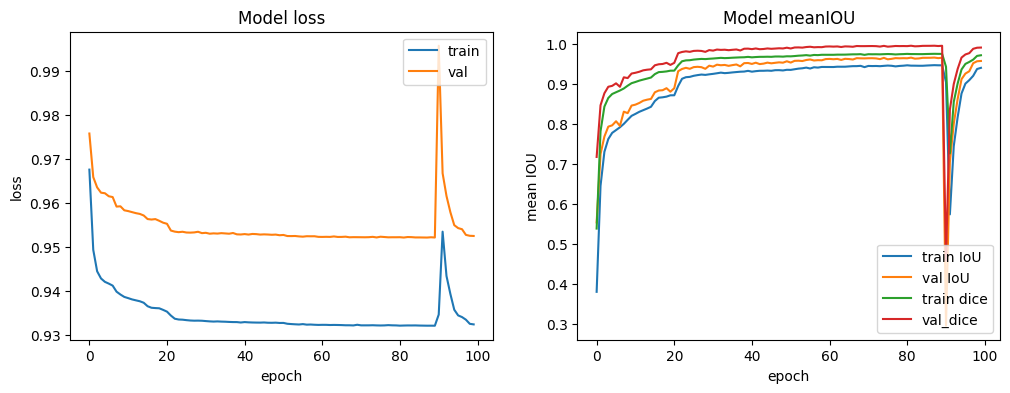

In [14]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(H['train_loss'])
plt.plot(H['test_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')

plt.subplot(122)
plt.plot(H['train_IoU'])
plt.plot(H['test_IoU'])
plt.plot(H['train_DC'])
plt.plot(H['test_DC'])
plt.title('Model meanIOU')
plt.ylabel('mean IOU')
plt.xlabel('epoch')

plt.legend(['train IoU', 'val IoU', 'train dice', 'val_dice'], loc='lower right')

plt.show()

In [15]:
def make_prediction(model, image):
	image = torch.Tensor(image).permute((2, 0, 1)).to(DEVICE)
	image = torch.unsqueeze(image, 0)
	# set model to evaluation mode
	model.eval()
	# turn off gradient tracking
	with torch.no_grad():
		predMask = model(image)
		predMask = softmax(predMask)
		predMask = torch.squeeze(predMask, 0)
		predMask = predMask.permute((1, 2, 0))
		predMask = predMask.cpu().detach().numpy()
		predMask = np.argmax(predMask, axis=-1)
		predMask = np.expand_dims(predMask, axis=-1)
		# filter out the weak predictions and convert them to integers
		return predMask.astype(np.uint8)


In [16]:
def getPredImg(image_path):     
    image = cv2.imread(image_path)
    image = image[10:-10, 10:-10,:]
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (INPUT_IMAGE_WIDTH, INPUT_IMAGE_HEIGHT))
    image = image / 255
    return image

def getPredMask(mask_path):
    mask = cv2.imread(mask_path)
    mask = mask[10:-10, 10:-10,:]
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    mask = cv2.resize(mask, (INPUT_IMAGE_WIDTH, INPUT_IMAGE_HEIGHT), interpolation=cv2.INTER_NEAREST)
    mask = np.expand_dims(mask, axis=-1)
    mask = encode_mask(mask)
    return mask

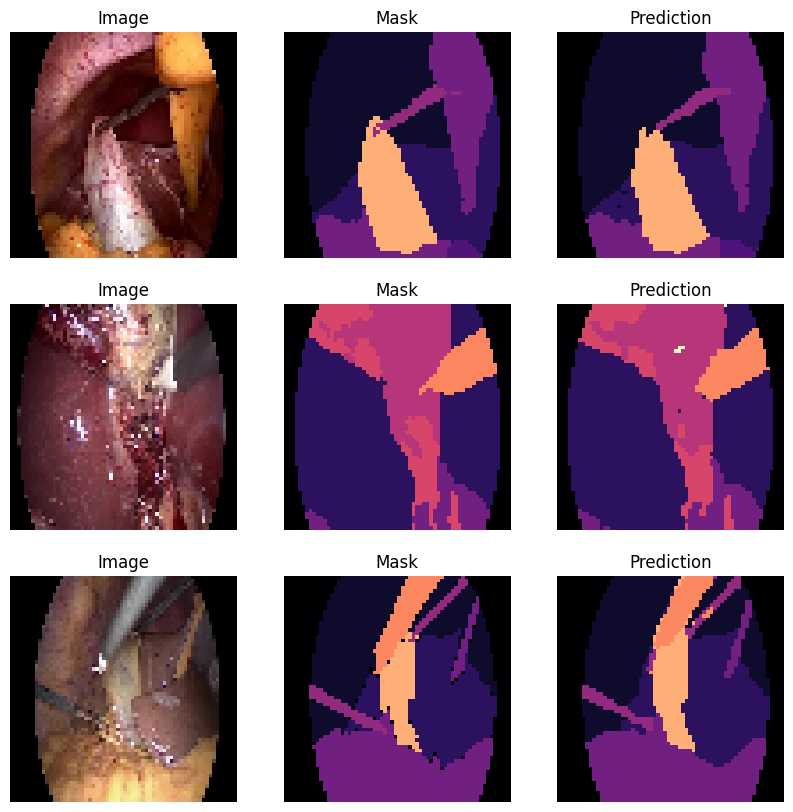

In [19]:
plt.figure(figsize=(10,10))
for i in range(3):    

    idx = random.randint(0, len(testImages) -1)
    img = getPredImg(testImages[idx])
    mask = getPredMask(testMasks[idx])
    
    plt.subplot(331 + 3*i)
    plt.imshow(img)
    plt.title('Image')
    plt.axis("off")

    mask = np.argmax(mask, axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    plt.subplot(332 + 3*i)
    plt.imshow(mask, cmap='magma', norm=plt.Normalize(vmin=0, vmax=12))
    plt.title('Mask')
    plt.axis("off")

    pred = make_prediction(uformer, img)
    plt.subplot(333 + 3*i)
    plt.imshow(pred, cmap='magma', norm=plt.Normalize(vmin=0, vmax=12))
    plt.title('Prediction')
    plt.axis("off")

plt.show()

 --- 
 TFG - Alejandro García Mota